In [1]:
import numpy as np
import rasterio.warp

Change the file path and filename to match your file. 

In [2]:
path = ""
file_name_no_extension = "dnk_ppp_2020_constrained"

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

filename = f"{path}{file_name_no_extension}.tif"
with rasterio.open(filename) as dataset:
    val = dataset.read(1)  # band 5
    no_data = dataset.nodata
    geometry = [
        Point(dataset.xy(x, y)[0], dataset.xy(x, y)[1])
        for x, y in np.ndindex(val.shape)
        if val[x, y] != no_data
    ]
    v = [val[x, y] for x, y in np.ndindex(val.shape) if val[x, y] != no_data]
    df = gpd.GeoDataFrame({"geometry": geometry, "data": v})
    df.crs = dataset.crs
df.head()

,geometry,data
0,POINT (10.60083 57.74333),1.206668
1,POINT (10.60167 57.74333),0.982903
2,POINT (10.63333 57.74333),0.970523
3,POINT (10.63083 57.74083),1.223284
4,POINT (10.59583 57.74),1.048370


In [ ]:
from data_loader.osm import download_osm_graph
import osmnx as ox

# Load graph
G = download_osm_graph(
    [
        "Copenhagen Municipality, Denmark",
        "Frederiksberg Municipality, Denmark",
        "Tårnby Municipality, Denmark",
        "Hvidovre Municipality, Denmark",
        "Rødovre Municipality, Denmark",
        "Gentofte Municipality, Denmark",
        "Gladsaxe Municipality, Denmark",
        "Herlev Municipality, Denmark",
    ]
)

In [ ]:
# Filter df data to only include points within the graph
nodes, edges = ox.graph_to_gdfs(G)
xmin, ymin, xmax, ymax = nodes.total_bounds
gdf_filtered = df[
    (df.geometry.x > xmin)
    & (df.geometry.x < xmax)
    & (df.geometry.y > ymin)
    & (df.geometry.y < ymax)
]
print(gdf_filtered.shape)
gdf_filtered.head()

In [ ]:
nodes.head()

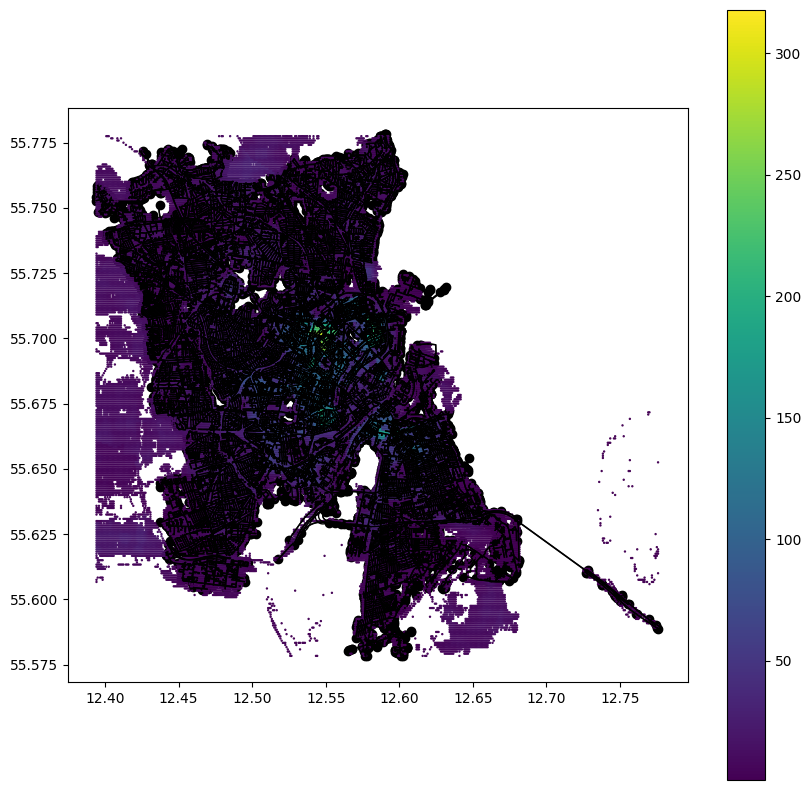

In [31]:
# plot the gdf_filtered
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
nodes.plot(ax=ax, facecolor="black")
edges.plot(ax=ax, linewidth=1, edgecolor="black")
## make points smaller
gdf_filtered.plot(ax=ax, column="data", legend=True, markersize=0.5)

plt.show()

In [ ]:
from shapely.geometry import Polygon

# Define the polygon from coordinates, this is a top part of Amager
coords = [
    (12.594274044129435, 55.66867990825105),
    (12.594274044129435, 55.66233625713531),
    (12.610694718998047, 55.66233625713531),
    (12.610694718998047, 55.66867990825105),
    (12.594274044129435, 55.66867990825105),
]

polygon = Polygon(coords)
xmin, ymin, xmax, ymax = polygon.bounds
cphSmall = df[
    (df.geometry.x > xmin)
    & (df.geometry.x < xmax)
    & (df.geometry.y > ymin)
    & (df.geometry.y < ymax)
]
print(len(cphSmall))
cphSmall.head()

smallNodes = nodes.cx[xmin:xmax, ymin:ymax]
smallEdges = edges.cx[xmin:xmax, ymin:ymax]

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
smallNodes.plot(ax=ax, facecolor="black")
smallEdges.plot(ax=ax, linewidth=1, edgecolor="black")
## make points smaller
cphSmall.plot(ax=ax, column="data", legend=True, markersize=100)

plt.show()

In [ ]:
nearestnodesToPop = {}
for id in cphSmall.index:
    point = cphSmall.loc[id].geometry
    pop = cphSmall.loc[id].data
    (nearest_node, dist) = ox.distance.nearest_nodes(
        G, point.x, point.y, return_dist=True
    )
    if dist < 100:  # more than 100 meters away, dont add it to the pop
        if nearest_node not in nearestnodesToPop:
            nearestnodesToPop[nearest_node] = pop
        else:
            nearestnodesToPop[nearest_node] += pop
cphSmallPop = gpd.GeoDataFrame(
    {
        "id": list(nearestnodesToPop.keys()),
        "pop": list(nearestnodesToPop.values()),
        "geometry": [nodes.loc[k].geometry for k in nearestnodesToPop.keys()],
    },
    geometry="geometry",  # Explicitly set geometry column
)
if nodes.crs:
    cphSmallPop.set_crs(
        nodes.crs, inplace=True
    )  # Set Coordinate Reference System from nodes
    cphSmallPop = cphSmallPop.to_crs(nodes.crs)  # Now reproject
else:
    raise ValueError("Nodes GeoDataFrame has no CRS defined!")

In [35]:
cphSmallPop.to_file("PopulationGeoDataframe.geojson", driver="GeoJSON")

/Users/mai/ITU/CS/semesters/Speciale/playground/venv/lib/python3.13/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


<Axes: >

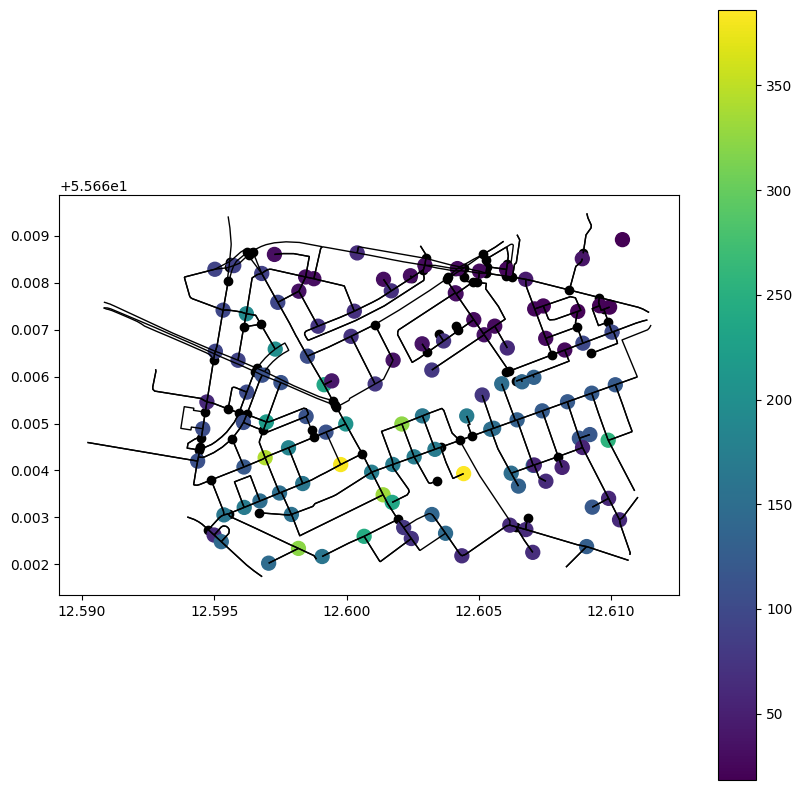

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))
smallNodes.plot(ax=ax, facecolor="black")
smallEdges.plot(ax=ax, linewidth=1, edgecolor="black")
## make points smaller
cphSmallPop.plot(ax=ax, column="pop", legend=True, markersize=100)